In [1]:
import datetime
import gc
import os
import pathlib
import random
import sys
sys.path.append('..')
from typing import Dict, List, Tuple, Union

from joblib import load
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold, TimeSeriesSplit
from sklearn.preprocessing import OrdinalEncoder

from scripts.evaluate import Evaluator
from scripts.get_logger import get_logger


gc.enable()

In [2]:
class PathHandler:
    competition_dir = pathlib.Path('../../inputs')
    parquet_files_dir = competition_dir.joinpath('parquet_files')
    feature_dir = pathlib.Path('../../outputs/features')
    now_time = datetime.datetime.now()
    dataset_dir = pathlib.Path('../../dataset')
    output_dir = pathlib.Path(
        '../../outputs/output_lgb/'
        + f'model_outputs_{now_time.date()}-{now_time.hour:02}-{now_time.minute:02}'
    )
    if not output_dir.is_dir():
        output_dir.mkdir(parents=True)


paths = PathHandler()

### load depth_data

In [3]:
depth_data = pd.read_parquet(paths.dataset_dir.joinpath('depth_data.parquet'))
depth_data = depth_data.query('is_test==0')
depth_data.drop(columns=['is_test'], inplace=True)
categorical_features = list(np.load(paths.dataset_dir.joinpath('categorical_features.npy'), allow_pickle=True))

depth_data.fillna({col: 'none' for col in categorical_features}, inplace=True)
depth_data[categorical_features] = depth_data[categorical_features].astype('category')

display(depth_data)
print(len(categorical_features))

display(depth_data.dtypes.value_counts())

,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P_0,amtinstpaidbefduel24m_4187115A_0,annuity_780A_0,annuitynextmonth_57A_0,applicationcnt_361L_0,...,diff_pmtssum_45A_0_annuity_780A_0,sum_pmtssum_45A_0_annuity_780A_0,diff_pmtssum_45A_0_credamount_770A_0,sum_pmtssum_45A_0_credamount_770A_0,diff_annuity_780A_0_credamount_770A_0,sum_annuity_780A_0_credamount_770A_0,year_date_decision,month_date_decision,day_date_decision,weekday_date_decision
0,0,2019-01-03,201901,0,0.0,NaN,NaN,1917.599976,0.000000,0.0,...,NaN,NaN,NaN,NaN,-28082.400391,31917.599609,2019,1,3,4
1,1,2019-01-03,201901,0,0.0,NaN,NaN,3134.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,-16865.800781,23133.800781,2019,1,3,4
2,2,2019-01-04,201901,0,0.0,NaN,NaN,4937.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,-73063.000000,82937.000000,2019,1,4,5
3,3,2019-01-03,201901,0,0.0,NaN,NaN,4643.600098,0.000000,0.0,...,NaN,NaN,NaN,NaN,-35356.398438,44643.601562,2019,1,3,4
4,4,2019-01-04,201901,0,1.0,NaN,NaN,3390.199951,0.000000,0.0,...,NaN,NaN,NaN,NaN,-40609.800781,47390.199219,2019,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0.0,0.0,176561.359375,3675.400146,0.000000,0.0,...,NaN,NaN,NaN,NaN,-26324.599609,33675.398438,2020,10,5,1
1526655,2703451,2020-10-05,202010,91,0.0,0.0,301276.468750,7088.600098,6191.600098,0.0,...,NaN,NaN,NaN,NaN,-92911.398438,107088.601562,2020,10,5,1
1526656,2703452,2020-10-05,202010,91,0.0,0.0,14232.400391,7788.800293,0.000000,0.0,...,NaN,NaN,NaN,NaN,-52211.199219,67788.796875,2020,10,5,1
1526657,2703453,2020-10-05,202010,91,0.0,0.0,197371.578125,1195.400024,2827.199951,0.0,...,NaN,NaN,NaN,NaN,-4804.600098,7195.399902,2020,10,5,1


120


float32     377
category      7
category      7
category      4
int64         3
           ... 
category      1
category      1
category      1
category      1
category      1
Name: count, Length: 89, dtype: int64

In [4]:
class CFG:
    def __init__(
            self,
            outputs_dir: pathlib.Path,
            n_splits: int = 5,
            boosting: str = 'gbdt',
            lr: float = 0.1,
            max_depth: int = -1,
            num_leaves: int = 31,
            min_data_in_leaf: int = 20,
            min_sum_hessian_in_leaf: float = 1e-03,
            bagging_fraction: float = 1.0,
            feature_fraction: float = 1.0,
            feature_fraction_bynode: float = 1.0,
            num_boost_round: int = 1000,
            lambda_l1: float = 0.0,
            lambda_l2: float = 0.0,
            seed: int = 42,
            device: str = 'cpu',
            num_threads: int = 0,
            is_unbalance: bool = False,
            drop_rate: float = 0.1,
            max_drop: int = 50,
            skip_drop: float = 0.5,
            extra_trees: bool = False,
            debag: bool = False,
        ):
        
        self.outputs_dir = outputs_dir
        self.n_splits = n_splits
        self.boosting = boosting
        self.lr = lr
        self.max_depth = max_depth
        self.num_leaves = num_leaves
        self.min_data_in_leaf = min_data_in_leaf
        self.min_sum_hessian_in_leaf = min_sum_hessian_in_leaf
        self.bagging_fraction = bagging_fraction
        self.feature_fraction = feature_fraction
        self.feature_fraction_bynode = feature_fraction_bynode
        self.num_boost_round = num_boost_round
        self.lambda_l1 = lambda_l1
        self.lambda_l2 = lambda_l2
        self.seed = seed
        self.device = device
        self.num_threads = num_threads
        self.is_unbalance = is_unbalance
        self.drop_rate = drop_rate
        self.max_drop = max_drop
        self.skip_drop = skip_drop
        self.extra_trees = extra_trees
        self.debag = debag
        
    def seed_everything(self):
        random.seed(self.seed)
        np.random.seed(self.seed)

In [5]:
def train(config, logger, X, categorical_features):
    
    kfold = StratifiedGroupKFold(
        n_splits=config.n_splits,
        shuffle=True,
        random_state=config.seed,
    )

    y = X['target'].copy()
    weeks = X[['WEEK_NUM']].copy()
    oof = X[['case_id', 'date_decision', 'WEEK_NUM', 'MONTH', 'target']].copy()
    oof_probas = -1 * np.ones(len(oof))
    folds = -1 * np.ones(len(oof))
    X.drop(columns=['case_id', 'date_decision', 'MONTH', 'WEEK_NUM', 'target'], inplace=True)
    display(X.dtypes.value_counts())
    display(oof)

    logger.info(f'number of features: {X.shape}')
    
    np.save(config.outputs_dir.joinpath('training_features.npy'), X.columns.to_numpy())
    np.save(config.outputs_dir.joinpath('categorical_features.npy'), categorical_features)
    
    fimps = pd.DataFrame(
        index=X.columns,
        columns=[f'fold_{k+1}_fimp' for k in range(config.n_splits)]
    )

    model_params = {
        'task': 'train',
        'boosting': config.boosting,
        'objective': 'binary',
        'metric': ['auc', 'average_precision', 'binary_logloss'],
        'learning_rate': config.lr,
        'seed': config.seed,
        'max_depth': config.max_depth,
        'num_leaves': config.num_leaves,
        'min_data_in_leaf': config.min_data_in_leaf,
        'min_sum_hessian_in_leaf': config.min_sum_hessian_in_leaf,
        'bagging_fraction': config.bagging_fraction,
        'feature_fraction': config.feature_fraction,
        'feature_fraction_bynode': config.feature_fraction_bynode,
        'lambda_l1': config.lambda_l1,
        'lambda_l2': config.lambda_l2,
        'device': config.device,
        #'max_bin': 100,
        'num_threads': config.num_threads,
        'extra_trees': config.extra_trees,
        'is_unbalance': config.is_unbalance,
    }
    if config.boosting == 'dart':
        model_params['drop_rate'] = config.drop_rate
        model_params['max_drop'] = config.max_drop
        model_params['skip_drop'] = config.skip_drop
    
    lgb.register_logger(logger) 
    
    for k, (train_indices, valid_indices) in enumerate(kfold.split(X=X, y=y, groups=weeks)):

        logger.info(f'fold: {k+1}')
        logger.info(f'# of train: {len(train_indices)}')
        logger.info(f'# of valid: {len(valid_indices)}')

        logger.info(f'train WEEK_NUM: {oof.iloc[train_indices]["WEEK_NUM"].unique()}')
        logger.info(f'valid WEEK_NUM: {oof.iloc[valid_indices]["WEEK_NUM"].unique()}')
        
        train_X = X.iloc[train_indices]
        valid_X = X.iloc[valid_indices]
        
        train_y = y.iloc[train_indices]
        valid_y = y.iloc[valid_indices]
        
        train_dataset = lgb.Dataset(
            data=train_X,
            label=train_y,
            categorical_feature=categorical_features,
        )
        valid_dataset = lgb.Dataset(
            data=valid_X,
            label=valid_y,
            categorical_feature=categorical_features,
            reference=train_dataset,
        )
        
        callbacks = [
            lgb.early_stopping(stopping_rounds=100, first_metric_only=True, verbose=True),
            lgb.log_evaluation(100),
        ]
        
        model = lgb.train(
            params=model_params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            valid_names=['train', 'valid'],
            callbacks=callbacks,
            num_boost_round=config.num_boost_round,
        )

        date = ''.join(config.outputs_dir.stem.split('-')[-4:])
        model.save_model(
            config.outputs_dir.joinpath(f'lgb_fold{k+1}_{date}.txt'),
            num_iteration=model.best_iteration
        )
        
        fimps.loc[X.columns, f'fold_{k+1}_fimp']  = model.feature_importance(
            importance_type='gain'
        )
        
        oof_probas[valid_indices] = model.predict(
            valid_X,
            num_iteration=model.best_iteration
        )
        folds[valid_indices] = k
        
        del train_X, train_y, valid_X, valid_y
        del train_dataset, valid_dataset
        del model
        gc.collect()
        
    oof.loc[:, 'probability'] = oof_probas
    oof.loc[:, 'fold'] = folds
    
    del oof_probas, folds
    gc.collect()

    logger.info('Done!\n')
    
    return oof, fimps

In [6]:
%%time


config = CFG(
    outputs_dir=paths.output_dir,
    boosting='gbdt',
    n_splits=5,
    lr=5e-02,
    max_depth=10,
    num_leaves=64,
    min_data_in_leaf=100,
    min_sum_hessian_in_leaf=1.0,
    bagging_fraction=0.8,
    feature_fraction=0.8,
    feature_fraction_bynode=0.8,
    num_boost_round=10000,
    lambda_l1=0.1,
    lambda_l2=10,
    seed=42,
    device='CPU',
    num_threads=int(os.cpu_count()*0.8),
    # drop_rate=0.3,
    # max_drop=50,
    # skip_drop=0.5,
    extra_trees=True,
    debag=False,
)
config.seed_everything()

logger = get_logger(paths.output_dir.joinpath('output.log'))

log = [
    f'{k} = {config.__dict__[k]}'
    for k, v in config.__dict__.items()
    if not k.startswith('__')
]
logger.info('\n'.join(log))
logger.info('\n')

if config.debag:
    depth_data = depth_data.sample(n=10000, random_state=config.seed)
    depth_data = depth_data.reset_index(drop=True)
    
oof, fimps = train(config, logger, depth_data, categorical_features)

2024-05-26 21:23:00,005 scripts.get_logger:34 <module> [INFO]:
outputs_dir = ../../outputs/output_lgb/model_outputs_2024-05-26-21-22
n_splits = 5
boosting = gbdt
lr = 0.05
max_depth = 10
num_leaves = 64
min_data_in_leaf = 100
min_sum_hessian_in_leaf = 1.0
bagging_fraction = 0.8
feature_fraction = 0.8
feature_fraction_bynode = 0.8
num_boost_round = 10000
lambda_l1 = 0.1
lambda_l2 = 10
seed = 42
device = CPU
num_threads = 19
is_unbalance = False
drop_rate = 0.1
max_drop = 50
skip_drop = 0.5
extra_trees = True
debag = False
2024-05-26 21:23:00,006 scripts.get_logger:35 <module> [INFO]:




float32     377
category      7
category      7
category      4
category      3
           ... 
category      1
category      1
category      1
category      1
category      1
Name: count, Length: 86, dtype: int64

,case_id,date_decision,WEEK_NUM,MONTH,target
0,0,2019-01-03,0,201901,0.0
1,1,2019-01-03,0,201901,0.0
2,2,2019-01-04,0,201901,0.0
3,3,2019-01-03,0,201901,0.0
4,4,2019-01-04,0,201901,1.0
...,...,...,...,...,...
1526654,2703450,2020-10-05,91,202010,0.0
1526655,2703451,2020-10-05,91,202010,0.0
1526656,2703452,2020-10-05,91,202010,0.0
1526657,2703453,2020-10-05,91,202010,0.0


2024-05-26 21:23:00,442 scripts.get_logger:18 train [INFO]:
number of features: (1526659, 502)
2024-05-26 21:23:00,872 scripts.get_logger:59 train [INFO]:
fold: 1
2024-05-26 21:23:00,873 scripts.get_logger:60 train [INFO]:
# of train: 1202502
2024-05-26 21:23:00,873 scripts.get_logger:61 train [INFO]:
# of valid: 324157
2024-05-26 21:23:00,895 scripts.get_logger:63 train [INFO]:
train WEEK_NUM: [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 25 26
 27 29 28 31 32 33 34 36 37 38 39 40 41 42 45 46 48 49 50 51 52 53 54 55
 56 57 60 61 62 64 66 67 68 69 70 71 72 73 77 78 79 81 82 83 84 85 87 88]
2024-05-26 21:23:00,902 scripts.get_logger:64 train [INFO]:
valid WEEK_NUM: [ 0  7 21 30 35 43 44 47 58 59 63 65 74 75 76 80 86 89 90 91]
2024-05-26 21:23:06,881 scripts.get_logger:221 _log_native [INFO]:
[LightGBM] [Info] Number of positive: 37982, number of negative: 1164520
2024-05-26 21:23:07,879 scripts.get_logger:221 _log_native [INFO]:
[LightGBM] [Info] Auto-choosing col-w

CPU times: user 8h 48min 46s, sys: 2min 32s, total: 8h 51min 19s
Wall time: 28min 18s


In [7]:
np.save(config.outputs_dir.joinpath('categorical_features.npy'), categorical_features)

,case_id,date_decision,WEEK_NUM,MONTH,target,probability,fold
0,0,2019-01-03,0,201901,0.0,0.053413,0.0
1,1,2019-01-03,0,201901,0.0,0.078671,0.0
2,2,2019-01-04,0,201901,0.0,0.063587,0.0
3,3,2019-01-03,0,201901,0.0,0.104800,0.0
4,4,2019-01-04,0,201901,1.0,0.115696,0.0
...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,91,202010,0.0,0.001075,0.0
1526655,2703451,2020-10-05,91,202010,0.0,0.001823,0.0
1526656,2703452,2020-10-05,91,202010,0.0,0.071484,0.0
1526657,2703453,2020-10-05,91,202010,0.0,0.002023,0.0


count    1.526659e+06
mean     3.082422e-02
std      5.572163e-02
min      2.690730e-05
25%      3.328992e-03
50%      1.059980e-02
75%      3.254990e-02
max      8.896674e-01
Name: probability, dtype: float64


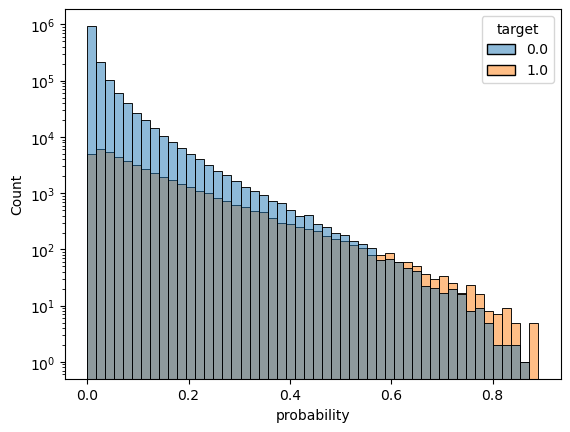

In [8]:
display(oof)
print(oof.query('probability != -1')['probability'].describe())

_, ax = plt.subplots()
sns.histplot(
    data=oof.query('probability != -1'),
    x='probability',
    hue='target',
    bins=50,
    ax=ax
)
plt.yscale('log')
plt.show()

,fold_1_fimp,fold_2_fimp,fold_3_fimp,fold_4_fimp,fold_5_fimp,fimp_mean,fimp_std
max_max_collater_typofvalofguarant_298M_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max_last_collaterals_typeofguarante_669M_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
last_last_subjectroles_name_541M_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max_last_subjectroles_name_541M_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max_max_collater_typofvalofguarant_407M_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
mean_dateofcredstart_739D_1,20598.162752,19473.418653,20246.863808,21292.892888,19898.369336,20301.941487,620.013844
mean_max_pmts_dpd_303P_2,13366.058788,30358.439674,24321.716999,21545.064755,14065.56699,20731.369441,6401.779444
max_incometype_1044T_1,19498.540255,21554.016398,20921.404955,24060.876086,22341.31161,21675.229861,1513.664107
max_mean_pmts_dpd_1073P_2,10915.385107,24459.642942,29145.834871,25190.93678,26383.037637,23218.967467,6355.236813


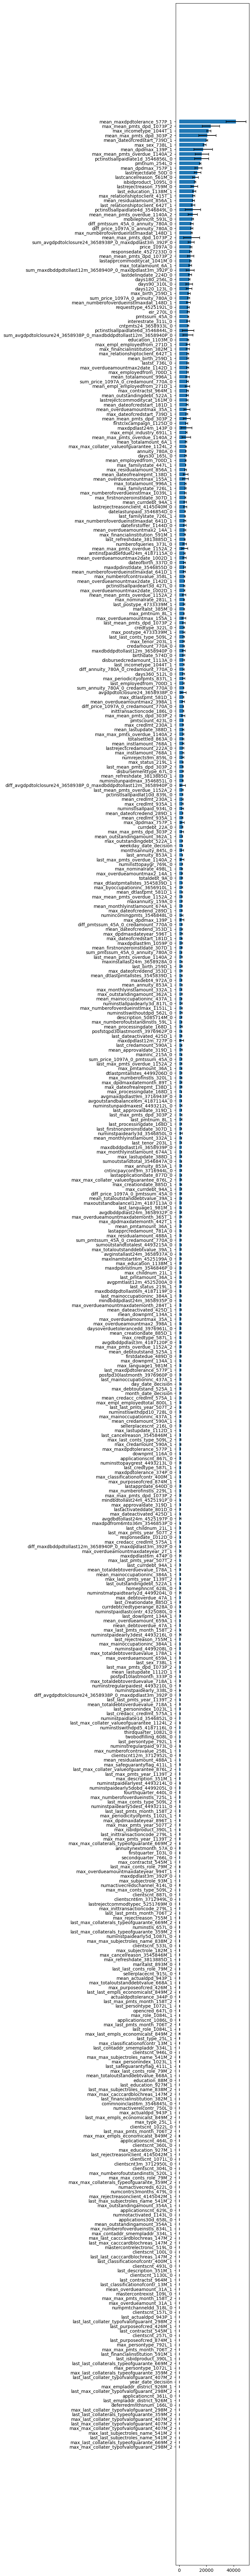

In [9]:
fimps['fimp_mean'] = fimps.mean(axis=1)
fimps['fimp_std'] = fimps.std(axis=1)
fimps.sort_values('fimp_mean', inplace=True)
display(fimps)

_, ax = plt.subplots(figsize=(8, 16*(len(fimps)//100)))
ax.barh(y=fimps.index, width=fimps['fimp_mean'], xerr=fimps['fimp_std'], capsize=3)
plt.tight_layout()
plt.show()

In [10]:
oof.to_csv(paths.output_dir.joinpath('oof.csv'), index=False)

fimps = fimps.reset_index(names=['processed_Variable'])
fimps.to_csv(paths.output_dir.joinpath('feature_importances.csv'), index=False)

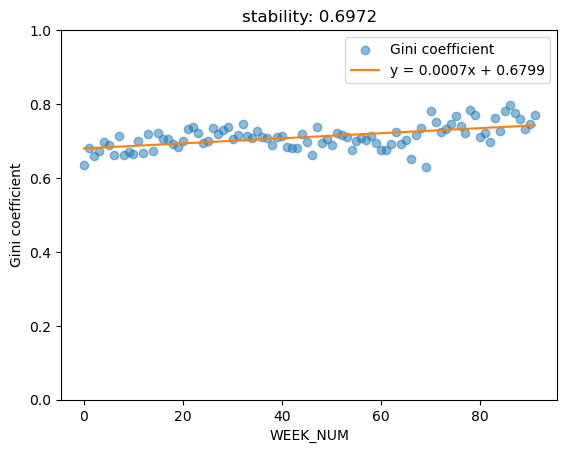

,WEEK_NUM,gini,regression,residuals
0,0,0.633953,0.679892,-0.045939
1,1,0.681489,0.680579,0.000910
2,2,0.660515,0.681266,-0.020751
3,3,0.672522,0.681954,-0.009432
4,4,0.697536,0.682641,0.014894
...,...,...,...,...
87,87,0.775697,0.739697,0.036000
88,88,0.758535,0.740385,0.018150
89,89,0.733709,0.741072,-0.007363
90,90,0.746773,0.741759,0.005014


2024-05-26 21:51:23,124 scripts.get_logger:6 <module> [INFO]:
stability: 0.6971974131488349
slope: 0.0006874205625879642
intercept: 0.6798915313006174



   stability     slope  intercept
0   0.697197  0.000687   0.679892
std(residuals) = 0.0279


In [11]:
evaluater = Evaluator(oof.query('probability!=-1'))
gini_per_week, outcome = evaluater.plot_gini()
display(gini_per_week)
print(outcome)

logger.info(
    f'stability: {outcome["stability"].item()}\n'
    + f'slope: {outcome["slope"].item()}\n'
    + f'intercept: {outcome["intercept"].item()}\n'
)

outcome.to_csv(paths.output_dir.joinpath('outcome.csv'), index=False)

print(f'std(residuals) = {gini_per_week["residuals"].std():.4f}')

In [12]:
from sklearn.metrics import roc_auc_score


oof_ = oof.copy()
display(oof_.groupby('WEEK_NUM')[['probability', 'target']].apply(lambda x: roc_auc_score(x['target'], x['probability'])))

WEEK_NUM
0     0.816976
1     0.840744
2     0.830257
3     0.836261
4     0.848768
        ...   
87    0.887848
88    0.879267
89    0.866854
90    0.873386
91    0.885395
Length: 92, dtype: float64